<a href="https://colab.research.google.com/github/brrikcy/deep-learning/blob/main/DL_EXP_09_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
try:
 tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # Get TPU resolver
 print('Running on TPU ', tpu.master())
except ValueError:
 print('TPU not found.')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# Define TPU
strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  


# Single layered LSTM (IMDb dataset)

In [ ]:
# Import Libraries
import numpy as npa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb

In [ ]:
# 1. Load IMDb dataset
max_features = 10000  # Top 10,000 most frequent words
maxlen = 200          # Maximum number of words in a review
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
# Pad sequences to ensure uniform input size
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [ ]:
# 2. Build the LSTM Model
model = Sequential([
    Embedding(input_dim=max_features, output_dim=128, input_length=maxlen),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 3. Train the Model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), verbose=2)

Epoch 1/5
391/391 - 202s - loss: 0.4513 - accuracy: 0.7836 - val_loss: 0.3233 - val_accuracy: 0.8643 - 202s/epoch - 516ms/step
Epoch 2/5
391/391 - 194s - loss: 0.2510 - accuracy: 0.9033 - val_loss: 0.3062 - val_accuracy: 0.8730 - 194s/epoch - 495ms/step
Epoch 3/5
391/391 - 193s - loss: 0.1898 - accuracy: 0.9282 - val_loss: 0.4118 - val_accuracy: 0.8522 - 193s/epoch - 495ms/step
Epoch 4/5
391/391 - 193s - loss: 0.1633 - accuracy: 0.9392 - val_loss: 0.3712 - val_accuracy: 0.8491 - 193s/epoch - 494ms/step
Epoch 5/5
391/391 - 194s - loss: 0.1240 - accuracy: 0.9547 - val_loss: 0.3963 - val_accuracy: 0.8607 - 194s/epoch - 495ms/step


In [ ]:
# 4. Evaluate the Model
score, accuracy = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Score: {score}")
print(f"Test Accuracy: {accuracy}")

391/391 [==============================] - 24s 60ms/step - loss: 0.3963 - accuracy: 0.8607
Test Score: 0.3962746560573578
Test Accuracy: 0.8607199788093567


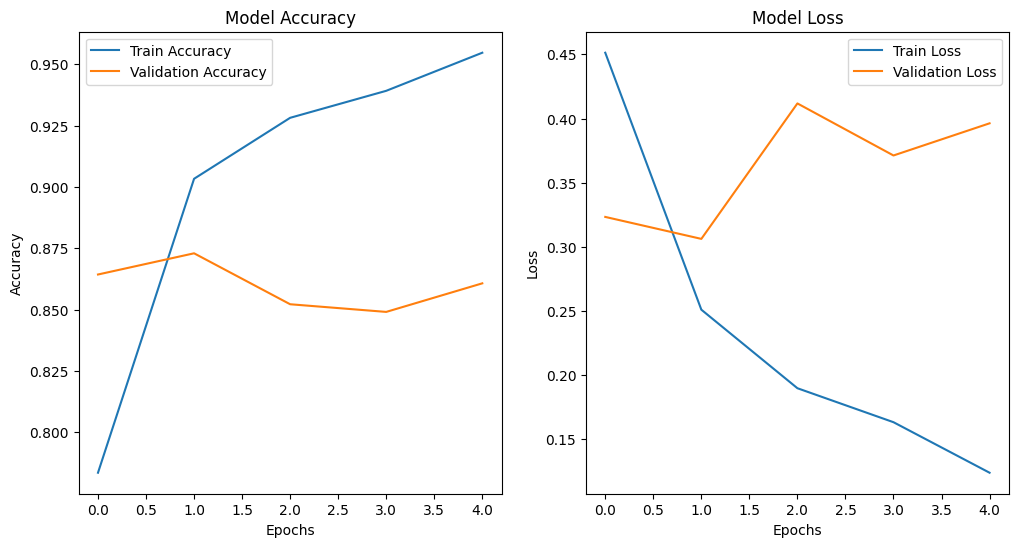

In [ ]:
# 5. Plot Accuracy and Loss
plt.figure(figsize=(12, 6))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 6. Predict on New Reviews
def predict_sentiment(review):
    word_index = imdb.get_word_index()
    tokens = [word_index.get(word, 0) for word in review.lower().split()]
    tokens_padded = pad_sequences([tokens], maxlen=maxlen)
    prediction = model.predict(tokens_padded)
    return "Positive" if prediction >= 0.5 else "Negative"

In [ ]:
# Test with a sample review
sample_review = "AMAZING MOVIE."
print(f"Review: {sample_review}\nPrediction: {predict_sentiment(sample_review)}")

1/1 [==============================] - 0s 40ms/step
Review: Movie is bad
Prediction: Negative


#Stacked LSTM (Stock price prediction)

In [ ]:
# Import Libraries
import numpy as np
import yfinance as yf
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
# 1. Load Data (Apple Stock Prices)
# Download historical stock data (last 5 years)
stock_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01')
stock_data = stock_data[['Adj Close']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 2. Preprocess the Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

In [ ]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [ ]:
# Function to create sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + ti
me_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [ ]:
time_steps = 60
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# 3. Build the Deep LSTM Model (Stacked LSTM)
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 4. Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# 5. Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.1065 - val_loss: 0.0048
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0065
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

In [ ]:
# Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f'RMSE: {rmse}')

RMSE: 6.735761227961217


In [ ]:
# 6. Make Predictions
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


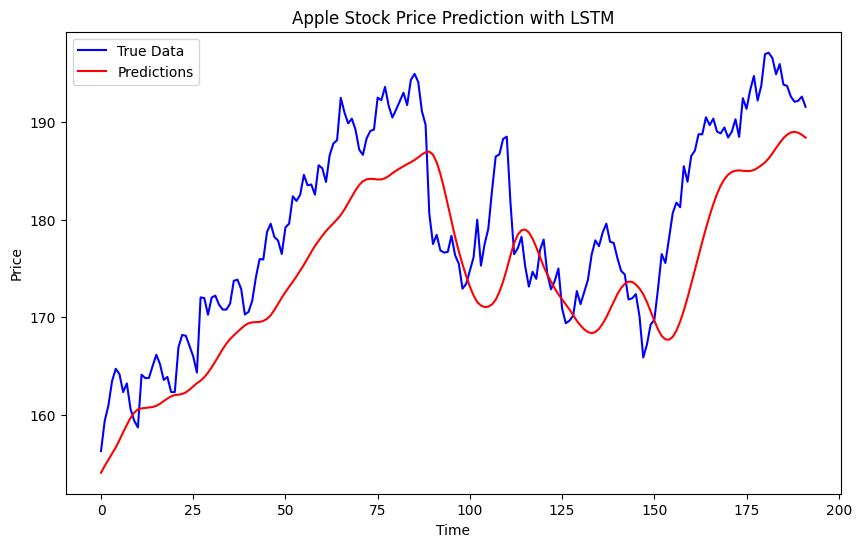

In [ ]:
# 7. Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Data', color='blue')
plt.plot(predictions_rescaled, label='Predictions', color='red')
plt.title('Apple Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()